In [ ]:
import sys

sys.path.insert(0, "../..")

import os
import shutil

import numpy as np
import pandas as pd
import torchvision.transforms.functional as F

from wildlife_datasets.datasets import AnimalCLEF2025, AnimalCLEF2025_LynxID2025, AnimalCLEF2025_SalamanderID2025
from wildlife_datasets.preparation import prepare_functions, resize_dataset
from wildlife_datasets.splits import OpenSetSplit, analyze_split

Specify folders.

In [2]:
root_datasets = "/data/wildlife_datasets/data"
root = os.path.join(root_datasets, "AnimalCLEF2025")
root_images = os.path.join(root, "images")
root_images_original = os.path.join(root, "images-unprocessed")
root_metadata = os.path.join(root, "metadata")
copy_files = False

Do preparation for the SeaTurtleID2022 dataset.

In [3]:
name = "SeaTurtleID2022"

prepare = prepare_functions["SeaTurtleID2022"]
metadata_database = prepare(
    root=f"{root_datasets}/{name}", new_root=f"{root_images}/{name}/database", copy_files=copy_files
)
prepare = prepare_functions["SeaTurtleID2022_AnimalCLEF2025"]
metadata_query = prepare(
    root=f"{root_images_original}/{name}", new_root=f"{root_images}/{name}/query", copy_files=copy_files
)

metadata_database["split"] = "database"
metadata_database["path"] = "database/" + metadata_database["path"]
metadata_query["species"] = "loggerhead turtle"
metadata_query["split"] = "query"
metadata_query["path"] = "query/" + metadata_query["path"]

metadata = pd.concat((metadata_database, metadata_query))
metadata = metadata.reset_index(drop=True)
metadata["image_id"] = range(len(metadata))

os.makedirs(f"{root_metadata}/{name}/", exist_ok=True)
metadata.to_csv(f"{root_metadata}/{name}/metadata.csv", index=False)

100%|██████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 22039.33it/s]


Do preparation for the LynxID2025 dataset.

In [4]:
name = "LynxID2025"

if copy_files:
    shutil.copytree(f"{root_images_original}/{name}/database", f"{root_images}/{name}/database", dirs_exist_ok=True)
    shutil.copytree(f"{root_images_original}/{name}/query", f"{root_images}/{name}/query", dirs_exist_ok=True)

d = AnimalCLEF2025_LynxID2025(f"{root_images_original}/{name}")
os.makedirs(f"{root_metadata}/{name}/", exist_ok=True)
d.metadata.to_csv(f"{root_metadata}/{name}/metadata.csv", index=False)

Do preparation for the SalamanderID2025 dataset.

In [ ]:
name = "SalamanderID2025"


class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, "constant")


# transform = SquarePad()
transform = None

splitter = OpenSetSplit(0.8, 0.1, seed=666)
dataset = AnimalCLEF2025_SalamanderID2025(f"{root_images_original}/{name}", img_load="bbox", transform=transform)
idx_train, idx_test = splitter.split(dataset.df)[0]

metadata_database = resize_dataset(
    dataset.get_subset(idx_train), f"{root_images}/{name}/database", copy_files=copy_files
)
metadata_query = resize_dataset(dataset.get_subset(idx_test), f"{root_images}/{name}/query", copy_files=copy_files)

metadata_database["split"] = "database"
metadata_database["path"] = "database/" + metadata_database["path"]
metadata_query["species"] = "salamander"
metadata_query["split"] = "query"
metadata_query["path"] = "query/" + metadata_query["path"]

metadata = pd.concat((metadata_database, metadata_query))
metadata = metadata.reset_index(drop=True)

os.makedirs(f"{root_metadata}/{name}/", exist_ok=True)
metadata.to_csv(f"{root_metadata}/{name}/metadata.csv", index=False)

100%|██████████████████████████████████████████████████████████| 689/689 [00:00<00:00, 24389.60it/s]


Merge all into one dataframe.

In [6]:
metadata = []
for name in ["LynxID2025", "SalamanderID2025", "SeaTurtleID2022"]:
    metadata_part = pd.read_csv(f"{root_metadata}/{name}/metadata.csv")
    metadata_part["dataset"] = name
    metadata_part["identity"] = name + "_" + metadata_part["identity"].astype(str)
    metadata_part["path"] = "images/" + name + "/" + metadata_part["path"]
    metadata.append(metadata_part)
metadata = pd.concat(metadata).reset_index(drop=True)
metadata["image_id"] = range(len(metadata))
metadata["orientation"] = metadata["orientation"].replace({"below": "down", "up": "top", "above": "top"})
metadata.to_csv(f"{root}/metadata.csv", index=False)

Load to verify integrity and plot a sample.

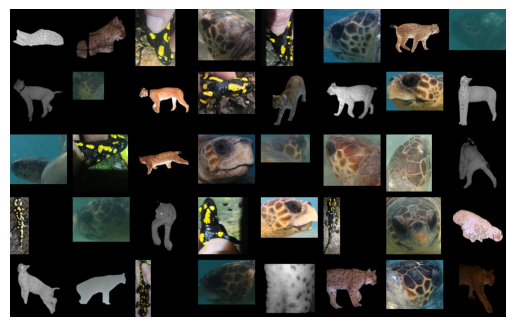

In [7]:
d = AnimalCLEF2025(root)
d.plot_grid();

Print some analysis of splits.

In [8]:
for dataset, df_dataset in d.df.groupby("dataset"):
    print(dataset)
    analyze_split(
        df_dataset,
        df_dataset[df_dataset["split"] == "database"].index,
        df_dataset[df_dataset["split"] == "query"].index,
    )

LynxID2025
Split: time-unaware open-set
Samples: train/test/unassigned/total = 2957/946/0/3903
Classes: train/test/unassigned/total = 77/41/0/99
Samples: train only/test only        = 2059/258
Classes: train only/test only/joint  = 58/22/19

Fraction of train set     = 75.76%
Fraction of test set only = 6.61%
SalamanderID2025
Split: time-unaware open-set
Samples: train/test/unassigned/total = 1388/689/0/2077
Classes: train/test/unassigned/total = 587/538/0/646
Samples: train only/test only        = 108/209
Classes: train only/test only/joint  = 108/59/479

Fraction of train set     = 66.83%
Fraction of test set only = 10.06%
SeaTurtleID2022
Split: time-cutoff open-set
Samples: train/test/unassigned/total = 8729/500/0/9229
Classes: train/test/unassigned/total = 438/100/0/488
Samples: train only/test only        = 7109/250
Classes: train only/test only/joint  = 388/50/50

Fraction of train set     = 94.58%
Fraction of test set only = 2.71%


Save the solution file.

In [9]:
df_database = d.get_subset(d.df["split"] == "database").df
df_query = d.get_subset(d.df["split"] == "query").df
new_identities = np.setdiff1d(df_query["identity"], df_database["identity"])

np.random.seed(666)
p = np.random.rand(len(df_query))
usage = np.repeat(["Private"], len(df_query))
usage[p <= 0.3] = "Public"

df_solution = pd.DataFrame(
    {
        "image_id": df_query["image_id"],
        "identity": df_query["identity"],
        "new_identity": df_query["identity"].apply(lambda x: x in new_identities),
        "dataset": df_query["dataset"],
        "Usage": usage,
    }
)
df_solution.to_csv("solution.csv", index=False)

d.df.loc[d.df["split"] == "query", "identity"] = np.nan
d.df.to_csv(f"{root}/metadata_hidden.csv", index=False)